In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from enum import IntEnum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import trange
from collections import defaultdict

from GrU_nn import (gru_module_1, gru_module_2, gru_module_3, gru_module_4, neuralGrU)
from GrU import (evaluate, GrU, getBestExporter, getCost)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

### Load auction data

In [3]:
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')

headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Revenue Maximisation

In [4]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [31]:
# Init model
eta = 1
scaler = 1
model = neuralGrU(B=128, eta_c=eta, eta_d=eta, alpha=1e3).to(device)

#### Input Data

In [6]:
# # Price vectors sampled from Normal Distribution(mu=0, sigma=1)
# prices = np.abs(np.random.normal(loc=0, scale=1, size=(5, 24))) * scaler

> Hyperparameters: lr = 0.125, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [32]:
# Price vectors sampled from Uniform Distribution [0, 1)
prices = np.random.random(size=(5, 24)) * scaler

> Hyperparameters: lr = 0.1, gamma = 0.94, B = 5, scaler = 1, Curriculum Learning & ExponentialLR Scheduler

In [8]:
# # Price vectors from Auction Data
# prices = getPriceVectors(300) * scaler

> Hyperparameters: lr = 1, gamma = 0.92, B = 1, scaler = 1 Curriculum Learning & ExponentialLR Scheduler

In [33]:
# Total demand tensor (Unit)
d_t = torch.ones(24, requires_grad=False, device=device) * 5
# d_t = torch.ones(24, requires_grad=False, device=device)

# Cap tensor
C_p = torch.ones(24, requires_grad=False) * 4

grid_shift = 0

# Price tensors
pi_g = torch.tensor(prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage], requires_grad=True, device=device)

#### Optimisation schedule

In [38]:
# Hyperparameter(s)
learning_rate = 0.008
epochs = 500

history = []
best_loss = 0

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t, C_p=C_p)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss / scaler)

    if loss < best_loss:
        pi_optimal, best_loss = [], loss
        for pi in pi_p, pi_s, pi_c, pi_d:
            pi_optimal.append(pi.clone().detach())

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e3:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:02<00:00, 185.99it/s]


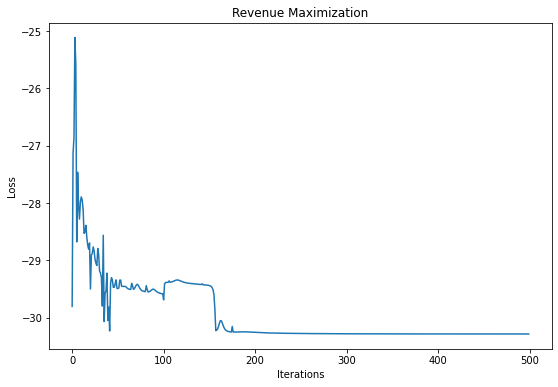

In [39]:
plt.figure(figsize=(9,6))
plt.plot(history, label='loss')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [28]:
best_loss, loss

(-23.753603698808092, -23.753603698808092)

In [20]:
pi_optimal

[tensor([0.3770, 0.2504, 0.3037, 0.4852, 0.7326, 0.5158, 0.8323, 0.6617, 0.2290,
         0.3850, 0.3915, 0.2598, 0.9135, 0.4653, 0.3898, 0.3455, 0.7714, 0.8909,
         0.5370, 0.3772, 0.7017, 0.2961, 0.3410, 0.9067], dtype=torch.float64),
 tensor([0.6380, 0.4698, 0.1426, 0.1598, 0.7335, 0.7910, 0.8173, 0.9350, 0.0285,
         0.9644, 0.8035, 0.6225, 0.2152, 0.8818, 0.2948, 0.5495, 0.3147, 0.4943,
         0.8144, 0.1159, 0.4038, 0.4639, 0.0040, 0.1761], dtype=torch.float64),
 tensor([0.5379, 0.5211, 0.5878, 0.0760, 0.1249, 0.1942, 0.4801, 0.0805, 0.4220,
         0.0561, 0.4866, 0.9112, 0.8969, 0.4629, 0.2414, 0.7545, 0.4939, 0.3432,
         0.2913, 0.3338, 0.2736, 0.0606, 0.5901, 0.5977], dtype=torch.float64),
 tensor([0.8268, 0.0740, 0.0063, 0.4675, 0.1160, 0.1361, 0.2127, 0.6625, 0.1446,
         0.7117, 0.3933, 0.3196, 0.8695, 0.9259, 0.6322, 0.2838, 0.8152, 0.3146,
         0.7103, 0.8849, 0.0638, 0.2658, 0.1581, 0.6177], dtype=torch.float64)]

In [36]:
torch.round(pi_g - pi_p, decimals=2)

tensor([ 0.0300, -0.6200, -0.2500, -0.3700,  0.0000, -0.3800, -0.5600,  0.2200,
        -0.2700,  0.0000, -0.5000,  0.0100,  0.1300, -0.8800,  0.0200,  0.0000,
         0.0000, -0.1500, -0.3100, -0.0700,  0.0300,  0.0200, -0.8100,  0.2000],
       dtype=torch.float64, grad_fn=<RoundBackward1>)

In [40]:
torch.round(d_star, decimals=2)

tensor([[1.0000, 5.0000, 5.0000, 5.0000, 1.0000, 5.0000, 5.0000, 1.0000, 5.0000,
         1.0000, 5.0000, 1.0000, 1.0000, 5.0000, 1.0000, 0.0100, 0.0100, 5.0000,
         5.0000, 5.0000, 1.0000, 1.0000, 5.0000, 1.0000],
        [4.0000, 0.0000, 0.0000, 0.0000, 4.0000, 0.0000, 0.0000, 4.0000, 0.0000,
         4.0000, 0.0000, 4.0000, 4.0000, 0.0000, 4.0000, 4.9900, 4.9900, 0.0000,
         0.0000, 0.0000, 4.0000, 4.0000, 0.0000, 4.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000

#### Demand breakup on optimised prices

In [294]:
pi = torch.stack([pi_g, pi_p, pi_s, pi_c, pi_d]).detach().numpy()

In [295]:
d_break_nn = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t).detach().numpy()
d_break, _ = GrU(d_t, pi, eta_c=eta, eta_d=eta)

In [296]:
evaluate(d_break, d_break_nn)[0]

[0.00016906086314523222, 0.00016906086314524837, 0.0, 0.0, 0.0]

In [297]:
d_break

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Revenue Maximisation with Gradient Clipping

1. No Curriculum Learning (for B). Init B at 10-20.
2. Gradients clipped at 0, i.e., updates to price(s) are non-negative.
3. Input price tensors are scaled to compensate for lower B.
4. ExponentialLR performs better than ReduceLROnPlateau.

In [298]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev

In [810]:
# Init model
eta = 1
B = 256
scaler = 1

model = neuralGrU(B, device, eta, eta).to(device)

#### Input Data

In [823]:
# prices = getPriceVectors(100) * scaler
scaled_prices = prices * scaler

# Random total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device)
# d_t = torch.ones(24, requires_grad=False, device=device)

# Price tensors
pi_g = torch.tensor(scaled_prices[source.grid] + grid_shift, requires_grad=False, device=device)

pi_p = torch.tensor(scaled_prices[source.pv],  requires_grad=True, device=device)
pi_c = torch.tensor(scaled_prices[source.charge], requires_grad=True, device=device)
pi_d = torch.tensor(scaled_prices[source.discharge], requires_grad=True, device=device)
pi_s = torch.tensor(scaled_prices[source.storage], requires_grad=True, device=device)

#### Optimization schedule

In [824]:
# Hyperparameter(s)
learning_rate = 0.025
epochs = 500

history_grad_clip = []

# Init optimizer & scheduler
optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.982)

for t in trange(epochs):
    # Compute prediction and loss
    d_star = model(pi_g, pi_p, pi_s, pi_c, pi_d, d_t)
    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    
    # Gradient Clipping
    for p in [pi_p, pi_s, pi_c, pi_d]:
        p.grad = -F.relu(-p.grad)

    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history_grad_clip.append(loss / scaler)

    # Curriculum Learning
    if t % 10 == 0 and model.B < 1e4:
        model.B *= 2

    # if t % 100 == 0:
    #     print(f"Epoch {t+1}     loss: {loss:>7f}")

100%|██████████| 500/500 [00:03<00:00, 162.10it/s]


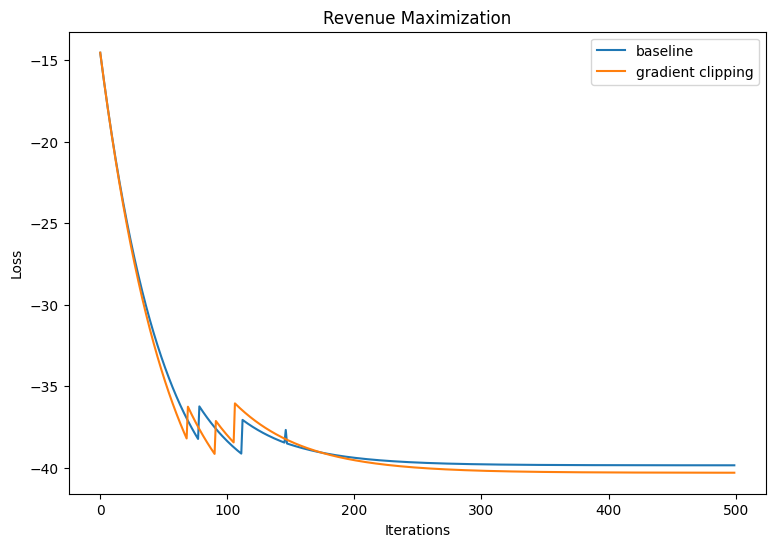

In [825]:
plt.figure(figsize=(9,6))
plt.plot(history, label='baseline')
plt.plot(history_grad_clip, label='gradient clipping')
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [558]:
(pi_g > pi_p).all()

tensor(True)

In [826]:
(pi_g - pi_p) / scaler

tensor([ 0.3661,  1.8690,  0.5150, -0.0408, -0.0312,  0.8866,  0.1038,  0.3904,
         1.3893,  0.8990,  0.1514,  1.9923,  0.6137,  0.7580,  0.5715,  0.3316,
         0.6517, -0.0619,  0.7804,  0.6153,  0.7038,  1.8420,  1.2148,  0.4223],
       dtype=torch.float64, grad_fn=<DivBackward0>)

In [827]:
np.round(d_star.detach().numpy())

array([[0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

## Multi-agent Revenue Maximization

In [68]:
def total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star):
    '''
    Loss = -revenue
    '''
    # r_g = pi_g * d_star[source.grid]
    r_p = pi_p * d_star[source.pv]
    r_s = pi_s * d_star[source.storage]
    r_c = pi_c * d_star[source.charge]
    r_d = pi_d * d_star[source.discharge]

    r_t = r_p + r_s + r_c + r_d
    rev = torch.sum(r_t)

    return -rev


def barrier_loss(C_g, C, epsilon, nan=1e3):
    '''
    Barrier function with barrier at C_g & sensitivity epsilon
    '''
    b = F.relu(-torch.log((C_g - C)/epsilon))

    return torch.sum(b)

In [65]:
prices = np.random.random((5, 24))

# Total demand tensor
d_t = torch.ones(24, requires_grad=False, device=device) * 2

# Global constraint
C_global = torch.ones(24, requires_grad=False, device=device) * 8

# Price tensors
pi_g = torch.tensor(prices[source.grid], requires_grad=False, device=device)

pi_p = torch.tensor(prices[source.pv], requires_grad=True, device=device)
pi_c = torch.tensor(prices[source.charge] * 1e3, requires_grad=True, device=device)
pi_d = torch.tensor(prices[source.discharge] * 1e3, requires_grad=True, device=device)
pi_s = torch.tensor(prices[source.storage] * 1e3, requires_grad=True, device=device)

# EI tensor
ep = [0.00044688, 0.00044796, 0.00045042, 0.00045573, 0.00046029, 0.00046002, 0.00045153, 0.00043737, 0.00042772, 0.00041107, 0.00040774, 0.00038668, 0.00037268, 0.00036565, 0.00036387, 0.00035763, 0.00034319, 0.00034377, 0.00035285, 0.00037902, 0.00039631, 0.00040366, 0.00039713, 0.00039088]
ep_t = torch.tensor(ep, requires_grad=False, device=device) * 1e3

In [69]:
n_agents = 5
gamma = [1, 2, 3, 4, 5]

models = {i: neuralGrU(B=64).to(device) for i in range(n_agents)}
d_star_n = torch.tensor(np.ndarray(shape=(n_agents, 5, 24)), device=device)
C_n = torch.ones(size=(n_agents, 24), requires_grad=True, device=device)

# Hyperparameter(s)
learning_rate = 0.01
epochs = 100
epsilon = 0.1
nan = 1e3

history = []

optimizer = torch.optim.Adam([pi_p, pi_s, pi_c, pi_d, C_n], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

for t in trange(epochs):
    for agent in range(n_agents):
        # Update pi_g with EI
        pi_g_ei = pi_g + gamma[agent] * ep_t
        d_star_n[agent] = models[agent](pi_g_ei, pi_p, pi_s, pi_c, pi_d, d_t, C_p=C_n[agent].clone())

    d_star_total = torch.sum(d_star_n, dim=0)
    C = torch.sum(C_n, dim=0)

    loss = total_loss(pi_g, pi_p, pi_s, pi_c, pi_d, d_star_total) + barrier_loss(C_global, C, epsilon, nan)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward(retain_graph=True)

    # Optimisation
    optimizer.step()
    scheduler.step()

    loss = loss.item()
    history.append(loss)

    # Curriculum Learning
    for agent in range(n_agents):
        if t % 10 == 0 and models[agent].B < 1e4:
            models[agent].B *= 2

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


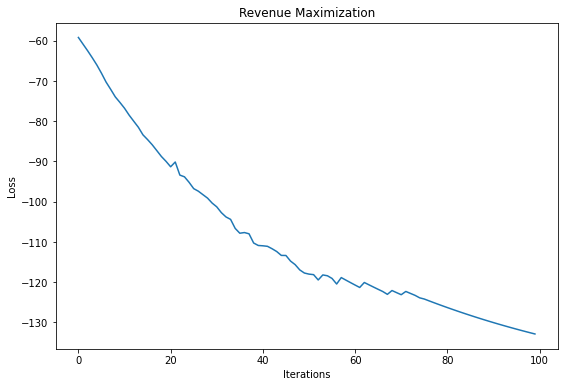

In [70]:
plt.figure(figsize=(9,6))
plt.plot(history)
plt.title('Revenue Maximization')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [71]:
pi_p

tensor([0.9821, 0.7931, 1.1817, 0.5286, 0.4661, 0.6123, 0.9646, 0.4898, 0.7090,
        1.4107, 1.2072, 1.4196, 0.7328, 0.9914, 0.9871, 0.4979, 1.3225, 0.5347,
        0.8283, 0.5918, 0.9789, 0.9222, 0.6482, 0.5340], dtype=torch.float64,
       requires_grad=True)

In [72]:
ep_t * 3 + pi_g

tensor([2.2393, 1.7002, 1.6407, 2.0142, 1.3894, 2.2716, 2.3006, 1.3389, 1.5753,
        2.1562, 1.9347, 2.0967, 1.4832, 1.3383, 1.6613, 1.5001, 2.0201, 1.4039,
        1.1830, 1.7954, 1.8050, 1.3311, 2.0573, 1.3316], dtype=torch.float64)

In [77]:
pi_g - pi_p

tensor([-0.0835, -0.4368, -0.8922,  0.1183, -0.4575,  0.2793, -0.0186, -0.4630,
        -0.4169, -0.4877, -0.4957, -0.4829, -0.3676, -0.7500, -0.4175, -0.0707,
        -0.3319, -0.1621, -0.7038,  0.0665, -0.3628, -0.8021,  0.2178, -0.3751],
       dtype=torch.float64, grad_fn=<SubBackward0>)

### Local PV Constraint

In [78]:
C_n

tensor([[1.4654, 1.2945, 1.0000, 1.5081, 1.3214, 1.4938, 1.4661, 1.3364, 1.4508,
         1.3948, 1.3808, 1.3688, 1.4533, 1.0000, 1.4255, 1.5144, 1.4557, 1.5069,
         1.0000, 1.4968, 1.4655, 1.0000, 1.4890, 1.3181],
        [1.4654, 1.4371, 1.4337, 1.5081, 1.4382, 1.4938, 1.4661, 1.4794, 1.4562,
         1.4539, 1.4576, 1.4532, 1.4634, 1.3757, 1.4649, 1.5144, 1.4557, 1.5069,
         1.3563, 1.4968, 1.4655, 1.4330, 1.4890, 1.4347],
        [1.4654, 1.4371, 1.4474, 1.5081, 1.4382, 1.4938, 1.4661, 1.4794, 1.4562,
         1.4539, 1.4576, 1.4532, 1.4634, 1.4404, 1.4649, 1.5144, 1.4557, 1.5069,
         1.4384, 1.4968, 1.4655, 1.4447, 1.4890, 1.4347],
        [1.4654, 1.4371, 1.4474, 1.5081, 1.4382, 1.4938, 1.4661, 1.4794, 1.4562,
         1.4539, 1.4576, 1.4532, 1.4634, 1.4404, 1.4649, 1.5144, 1.4557, 1.5069,
         1.4384, 1.4968, 1.4655, 1.4447, 1.4890, 1.4347],
        [1.4654, 1.4371, 1.4474, 1.5081, 1.4382, 1.4938, 1.4661, 1.4794, 1.4562,
         1.4539, 1.4576, 1.4532, 1.4634

### Total PV demand of all agents

In [76]:
torch.sum(d_star_n[:, 1], dim=0)

tensor([7.3190, 7.0358, 5.7703, 7.5319, 7.0671, 7.4603, 7.3227, 5.9115, 7.2686,
        5.8095, 5.8242, 5.8069, 7.2994, 4.3171, 5.8533, 7.5632, 7.2711, 7.5258,
        5.6657, 7.4755, 7.3197, 5.7616, 7.4367, 7.0499], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [75]:
torch.round(d_star_n[:, 1], decimals=2)

tensor([[1.4600, 1.2900, 0.0000, 1.5100, 1.3200, 1.4900, 1.4600, 0.0000, 1.4500,
         0.0000, 0.0000, 0.0000, 1.4500, 0.0000, 0.0000, 1.5100, 1.4500, 1.5100,
         0.0000, 1.5000, 1.4600, 0.0000, 1.4900, 1.3200],
        [1.4600, 1.4400, 1.4300, 1.5100, 1.4400, 1.4900, 1.4600, 1.4800, 1.4500,
         1.4500, 1.4600, 1.4500, 1.4600, 0.0000, 1.4600, 1.5100, 1.4500, 1.5100,
         1.3500, 1.5000, 1.4600, 1.4300, 1.4900, 1.4300],
        [1.4600, 1.4400, 1.4500, 1.5100, 1.4400, 1.4900, 1.4600, 1.4800, 1.4500,
         1.4500, 1.4600, 1.4500, 1.4600, 1.4400, 1.4600, 1.5100, 1.4500, 1.5100,
         1.4400, 1.5000, 1.4600, 1.4400, 1.4900, 1.4300],
        [1.4600, 1.4400, 1.4500, 1.5100, 1.4400, 1.4900, 1.4600, 1.4800, 1.4500,
         1.4500, 1.4600, 1.4500, 1.4600, 1.4400, 1.4600, 1.5100, 1.4500, 1.5100,
         1.4400, 1.5000, 1.4600, 1.4400, 1.4900, 1.4300],
        [1.4600, 1.4400, 1.4500, 1.5100, 1.4400, 1.4900, 1.4600, 1.4800, 1.4500,
         1.4500, 1.4600, 1.4500, 1.4600

> PV demand of all 5 users